# Adversarial Examples Attack

This notebook demonstrates the application of ART's tools for expectation over transformation (EoT) sampling in `art.preprocessing.expectation_over_transformation`. Specifically, it shows how to create adversarial examples that are robust against rotation. This notebook follows a tutorial by Anish Athalye (https://www.anishathalye.com/2017/07/25/synthesizing-adversarial-examples/) and code from issue #1004.

##Step 1: Initialization

In [ ]:
!pip install tensorflow_addons
!pip install git+https://github.com/nottombrown/imagenet_stubs
!pip install --upgrade tensorflow
!pip install adversarial-robustness-toolbox

In [2]:
import json

import scipy
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications.inception_v3 import InceptionV3

import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import label_to_name, name_to_label

from art.estimators.classification import TensorFlowV2Classifier
from art.preprocessing.expectation_over_transformation import EoTImageRotationTensorFlow
from art.attacks.evasion import ProjectedGradientDescent

In [3]:
np.random.seed(1234)

In [4]:
def plot_prediction(img, probs, correct_class=None, target_class=None):

    # Initialize the subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))

    # Set the first plot to the input image
    fig.sca(ax1)
    ax1.imshow(img)

    # Determine the top ten labels and store them with their probabilities
    top_ten_indexes = list(probs[0].argsort()[-10:][::-1])
    top_probs = probs[0, top_ten_indexes]
    labels = [label_to_name(i) for i in top_ten_indexes]
    barlist = ax2.bar(range(10), top_probs)
    if target_class in top_ten_indexes:
        barlist[top_ten_indexes.index(target_class)].set_color('r')
    if correct_class in top_ten_indexes:
        barlist[top_ten_indexes.index(correct_class)].set_color('g')

    # Plot the probabilities and labels
    plt.sca(ax2)
    plt.ylim([0, 1.1])
    plt.xticks(range(10), labels, rotation='vertical')
    plt.ylabel("Probability")
    fig.subplots_adjust(bottom=0.2)
    plt.show()
    print(top_probs)

## Step 2: Define parameters

In [5]:
# parameters that can be modified for experimentation

eps = 8.0 / 255.0 # Attack budget for PGD
eps_step = 2.0 / 255.0 # Step size for PGD
num_steps = 30 # Number of iterations for PGD
y_target = np.array([name_to_label("guacamole")])  # Target class for the attack is "guacamole"
angle_max = 22.5 # Rotation angle used for evaluation in degrees
eot_angle = angle_max # Maximum angle for sampling range in EoT rotation, applying range [-eot_angle, eot_angle]
eot_samples = 10 # Number of samples with random rotations in parallel per loss gradient calculation

# constant parameters
nb_classes = 1000 # Number of ImageNet classes
preprocessing = (0.5, 0.5) # Preprocessing with (mean, std) for InceptionV3 from input image range [0, 1]
clip_values=(0.0, 1.0) # Clip values for range [0, 1]
input_shape = (299, 299, 3) # Shape of input images

## Step 3: Load ImageNet data and labels

In [6]:
for i, image_path in enumerate(imagenet_stubs.get_image_paths()):
    im = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    im = tf.keras.preprocessing.image.img_to_array(im)
    if 'tractor.jpg' in image_path:
        x = np.array(im)
x = (np.expand_dims(x, axis=0) / 255.0).astype(np.float32)
y = np.array([name_to_label("tractor")])

## Step 4: Load InceptionV3 model and define cross-entropy loss

In [7]:
model = InceptionV3(include_top=True, weights='imagenet', classifier_activation='softmax')

96112376/96112376 [==============================] - 2s 0us/step


In [8]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

## Step 5: Create the ART Classifier and targeted attack using Projected Gradient Descent

In [9]:
classifier = TensorFlowV2Classifier(model=model,
                                    nb_classes=nb_classes,
                                    loss_object=loss,
                                    preprocessing=preprocessing,
                                    preprocessing_defences=None,
                                    clip_values=clip_values,
                                    input_shape=input_shape)

In [10]:
attack = ProjectedGradientDescent(estimator=classifier,
                                  eps=eps,
                                  max_iter=num_steps,
                                  eps_step=eps_step,
                                  targeted=True)

## Step 6: Generate and evaluate adversarial examples

In [11]:
# Generate adversarial examples
x_adv = attack.generate(x=x, y=y_target)

PGD - Batches: 0it [00:00, ?it/s]

## Step 7: Evaluate adversarial example

The targeted PGD attack (code and plots below) create a very successful adversarial example which is classified as `guacamole` with high confidence (red bar).

<font color='green'>Green bars</font> : correct classification<br>
<font color='red'>Red bars</font>: attack target classification<br>
<font color='blue'>Blue bars</font>: other classifications<br>

In [12]:
# Get predictions on adversarial examples
y_pred_adv = classifier.predict(x_adv)

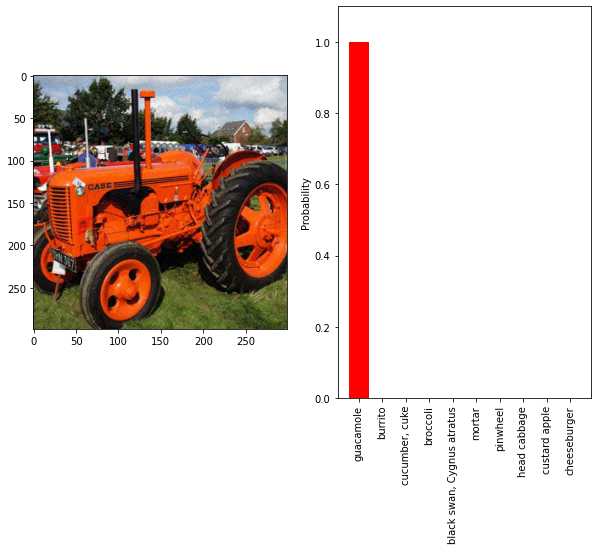

[1.0000000e+00 1.6276335e-08 1.5868361e-08 3.2444625e-09 2.0665822e-09
 1.9023183e-09 1.3962486e-09 1.3890608e-09 9.4292185e-10 8.1804891e-10]


In [13]:
# Evaluate results
plot_prediction(np.squeeze(x_adv), y_pred_adv, correct_class=y, target_class=y_target)

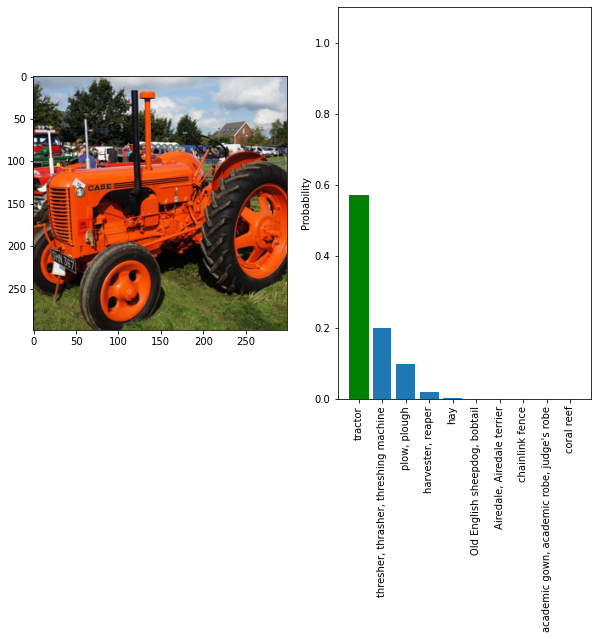

[5.7363230e-01 2.0006074e-01 9.9087223e-02 1.8049728e-02 9.4793906e-04
 8.3395495e-04 6.6696829e-04 6.5874192e-04 6.5583590e-04 4.9131084e-04]


In [14]:
#get prediction on pure example
y_pred_pure = classifier.predict(x)
plot_prediction(np.squeeze(x), y_pred_pure, correct_class=y, target_class=y_target)